In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import key, normal

jax.config.update("jax_enable_x64", True)

k = key(0)
x = normal(k, (20,))
is_cen = jnp.zeros((20,))
is_cen = is_cen.at[10:].set(1.0) 

In [2]:
from tensorflow_probability.substrates.jax import distributions as tfd

std_normal = tfd.Normal(0.0, 1.0)
F = std_normal.cdf(x)
logS = jnp.log1p(-jnp.clip(F, 0.0, 1.0 - 1e-16))   # stability

logf = std_normal.log_prob(x)
loglik = jnp.where(is_cen == 1.0, logS, logf)

print(loglik.sum())
print(loglik)

-26.611625517283905
[-0.94012401 -1.22686718 -2.56802392 -0.9365812  -0.92220832 -0.98817174
 -1.62718336 -0.97627782 -0.92253623 -1.29897169 -1.92535933 -0.06127908
 -1.03111733 -5.12792805 -0.92133999 -0.49153972 -0.35198371 -1.03154413
 -0.54873363 -2.71385505]


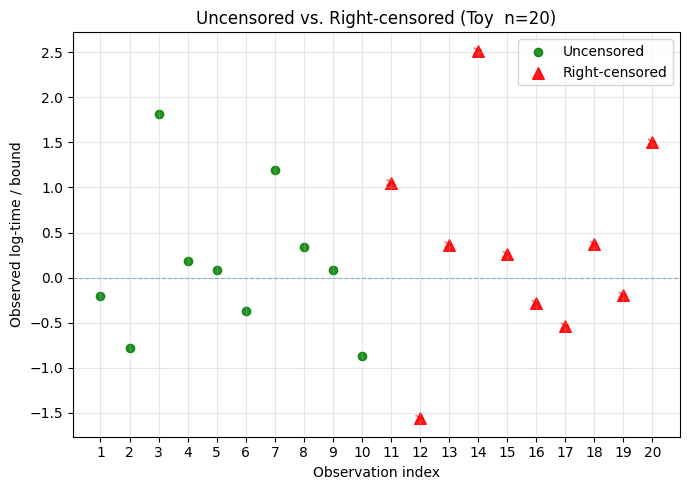

In [3]:
obs_idx = jnp.arange(1, len(x) + 1)

plt.figure(figsize=(7,5))
plt.scatter(obs_idx[is_cen==0], x[is_cen==0],
            label="Uncensored", color="green", marker="o", alpha=0.85)
plt.scatter(obs_idx[is_cen==1], x[is_cen==1],
            label="Right-censored", color="red", marker="^", s=70, alpha=0.9)

for idx, yi in zip(obs_idx[is_cen==1], x[is_cen==1]):
    plt.annotate("", xy=(idx+0.2, yi), xytext=(idx, yi),
                 arrowprops=dict(arrowstyle="->", lw=1, color="red", alpha=0.6))

plt.axhline(0.0, ls="--", lw=0.8, alpha=0.5)
plt.xlabel("Observation index")
plt.ylabel("Observed log-time / bound")
plt.title("Uncensored vs. Right-censored (Toy  n=20)")
plt.xticks(obs_idx)
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

In [4]:
class RightCensoredNormal(tfd.Distribution):
    """
    Minimal right-censored Normal in JAX/TFP with an indicator.

    Usage:
      dist = RightCensoredNormal(loc, scale, is_censored)
      logp = dist.log_prob(x)

    Semantics:
      - Uncensored (is_censored == 0):  log p(x) = Normal(loc, scale).log_prob(x)
      - Censored   (is_censored == 1):  log p(x) = log P(Y >= x)  (right-censoring at x)

    Shapes broadcast in the usual way. `is_censored` must be {0.0,1.0}.
    """

    def __init__(
        self,
        loc,
        scale,
        is_censored,
        validate_args=False,
        allow_nan_stats=True,
        name="RightCensoredNormal",
    ):
        parameters = dict(locals())
        self._loc = jnp.asarray(loc)
        self._scale = jnp.asarray(scale)
        self._is_censored = jnp.asarray(is_censored)
        self._normal = tfd.Normal(loc=self._loc, scale=self._scale)
        super().__init__(
            dtype=self._loc.dtype,
            reparameterization_type=tfd.NOT_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            name=name,
        )

    def _log_prob(self, value):
        x = jnp.asarray(value)

        lp_unc = self._normal.log_prob(x) # Uncensored: density
        lp_cen = jnp.log(self._normal.survival_function(x)) # Censored: log survival

        return jnp.where(self._is_censored == 1.0, lp_cen, lp_unc)

liesel.model.model - INFO - Converted dtype of Value(name="x_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


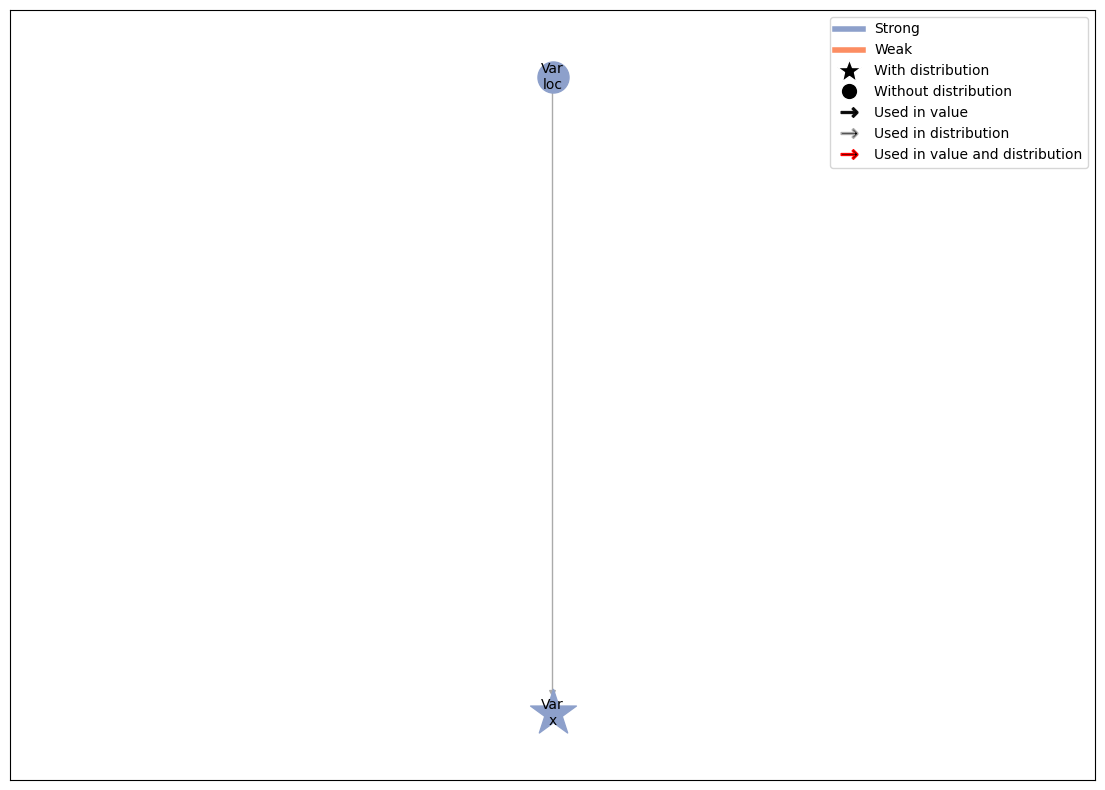

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'loc'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:01<00:00,  2.06chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 2, 2, 2, 2 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1748.36chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 1, 1, 2 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/

In [5]:
import liesel.model as lsl
import liesel.goose as gs

loc = lsl.Var.new_param(0.0, name="loc", inference=gs.MCMCSpec(gs.NUTSKernel))
dist = lsl.Dist(RightCensoredNormal, loc=loc, scale=1.0, is_censored=is_cen)

xvar = lsl.Var.new_obs(x, dist, name="x")
model = lsl.Model([xvar])
model.plot_vars()

eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)
eb.set_duration(warmup_duration=300, posterior_duration=500)
engine = eb.build()
engine.sample_all_epochs()

result = engine.get_results()

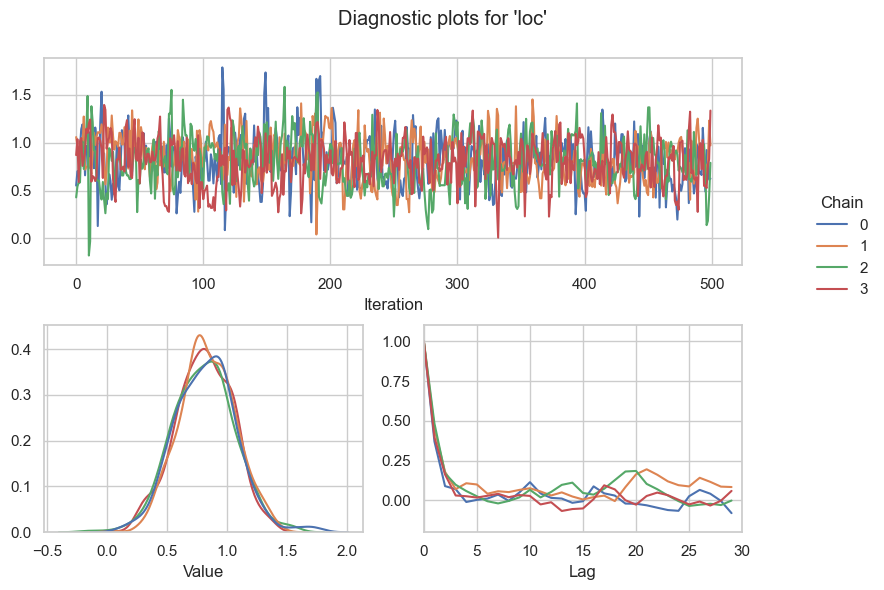

In [6]:
gs.Summary(result)
gs.plot_param(result, "loc")